<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.08.02.Colab_S1_Flooding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

# Sentinel-1 Flooding
<br>
This notebook uses Sentinel-1 data to detect water extent and flooding. Since radar can penetrate clouds, it is possible to get consistent time series views of a region at 6-day or 12-day revisits based on the use of one or two Sentinel-1 missions. If the region of interest falls within a scene overlap, it may be possible to get even more frequent visits. This notebook includes several different data products including histograms to find a good threshold for water detection, a single date VH-band threshold product to identify water extent, and a multi-date change product to identify new flooding.
<br><br>
The core data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from early 2017 for the globe. It is important to note that this data does NOT include radiometric terrain correction (RTC) so there are issues using this data in mountaineous areas. In addition, users are recommended to only compare scenes from the same pass direction (ascending or descending) and orbit path to avoid viewing geometry issues. 
<br><br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

## Load the Data Cube Configuration and Import Utilities

In [ ]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Select and data platform and product
# NOTE: Data from both Sentinel-1A and Sentinel-1B missions are included
platform = 'Sentinel-1A'
product = 's1_google'

## Define the Extents of the Analysis and View
Select the center of an analysis region (lat_long) below. The size of the region (in degrees) that surrounds this center point is defined using the "box_size_deg" parameter. Users can select one of the sample regions or add a new region. Use the map below to zoom in-or-out to find other regions. Click on the map to view a Lat-Lon position. After selecting an analysis region, you can also select a time window by defining the start date and end date for the "time_extents" parameter. To avoid issues with exceeding memory limits, users should start with small regions (<0.20 degrees) and small time windows (a few months) before expanding to larger analyses.

In [5]:
# MODIFY HERE

# Select the center of an analysis region (lat_long) 
# Adjust the surrounding box size (box_size) around the center (in degrees)
# Several example flooding cases are shown below.

# San Miguel, El Salvador 
# Heavy rain, May 31 to June 6 - Tropical Storm Amanda
# Time Extents = 2020-05-25 to 2020-06-15
# Compare: Dry 05-27, Flooded 06-08 
# lat_long = (13.298, -88.249)
# box_size_deg = 0.10

# Villahermosa, Tabasco, Mexico
# Flooding from Tropical Storm Eta
# Time Extents = 2020-09-15, 2020-11-15
# Dry on 09-22, Flooded on 11-09
# lat_long = (17.972, -92.885)
# box_size_deg = 0.22

# Luxembourg 
# Heavy Rains and Flooding on July 15, 2021
# Time Extents = 2021-07-01 to 2021-07-16
# Compare: Dry 07-03, Flooded 07-15
# lat_long = (49.53, 6.09)
# box_size_deg = 0.22

# Les Cayes, Haiti - Large Region
# Tropical Depression Grace - August 2021
# lat_long = (18.2399, -73.7919)
# box_size_deg = 0.30

# Duci, Haiti
# lat_long = (18.2294, -73.8874)
# box_size_deg = 0.10

# Les Cayes, Haiti - Coast
# lat_long = (18.2096, -73.7284)
# box_size_deg = 0.10

# Les Cayes, Haiti - City on Coast
# lat_long = (18.1862, -73.7588)
# box_size_deg = 0.02

# Cayes-de-Jacmel, Haiti - City on Coast
lat_long = (18.2419, -72.3626)
box_size_deg = 0.15

In [6]:
# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [7]:
# MODIFY HERE

# Select a time period for the analysis by defining the start and end dates
# Consistent Sentinel-1 time series data is available from Jan-2017

time_extents = ('2021-08-01', '2021-08-19')

In [8]:
display_map(latitude,longitude)

## Load the Data and View the Available Dates

In [9]:
parameters = dict(product=product, platform=platform, measurements=['vv','vh'], 
                  time=time_extents, lat=latitude, lon=longitude, group_by='time')

In [10]:
sar_dataset = dc.load(**parameters)

In [11]:
from operator import itemgetter

def get_metadata(group):
    metadata = (set(), set(), set(), set())
    for ds in group:
        metadata[0].add(np.datetime64(ds.metadata_doc.get('properties').get('dtr:start_datetime'), 'D'))
        metadata[1].add(ds.metadata_doc.get('properties').get('gee:properties').get('orbitProperties_pass'))
        metadata[2].add(ds.metadata_doc.get('properties').get('gee:properties').get('platform_number'))
        metadata[3].add(ds.metadata_doc.get('properties').get('gee:properties').get('relativeOrbitNumber_start'))
    return tuple(map(lambda x: ', '.join([str(i) for i in x]), metadata))

parameters.update(group_by='time' if not parameters.get('group_by') else parameters['group_by'])
sar_metadata = sorted([get_metadata(groups)
                       for groups in dc.group_datasets(dc.find_datasets(**parameters),
                                                       parameters.get('group_by')).values],
                      key=itemgetter(0))

## Data Summary
The table below summarizes the available Sentinel-1 data. You will find different acquisition dates, pass directions (ascending or descending), missions (A=Sentinel-1A, B=Sentinel-1B) and orbit path numbers. Finding flooding requires comparisons of images from similar viewing angles. So, it is important to only compare acquisitions with the same orbit path number. You will find that the same orbit number can come from two missions (6-day separation) or one mission (12-day separation) but the pass direction (ascending or descending) will be the same. 

In [12]:
# Show acquisition indices and dates
pd.DataFrame(sar_metadata, columns=['Acquisition Date', 'Pass Direction', 'Mission', 'Orbit Number'])

,Acquisition Date,Pass Direction,Mission,Orbit Number
0,2021-08-05,ASCENDING,A,4
1,2021-08-10,DESCENDING,A,69
2,2021-08-17,ASCENDING,A,4


### Speckle Filtering using a Block Average Filter
Radar data is often "grainy" in appearance due to speckle (statistical noise) and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common "block averaging" filter to average the pixels surrounding any given pixel. Users can select an odd number filter window size (e.g. 3,5,7, etc.) to filter both the VV and VH data. A filter window size of 3 will average a 3x3 region around every pixel. Similarly, a filter window size of 5 will average a 5x5 region around a every pixel. 

In [13]:
# Setup dB to power conversion functions so that filters work on power values

def to_pwr(x):
    return 10**(x/10)
def to_db(x):
    return 10*np.log10(x)

In [14]:
# MODIFY HERE

# Users can select the block average filter size to define the level of speckle filtering. The baseline is 5.
# The filter size must be an odd number, such as 3,5,7, etc. 

from utils.data_cube_utilities.raster_filter import stats_filter_2d

# Set any null values to 0 before applying the filter to prevent issues
sar_dataset_filled = sar_dataset.where(~sar_dataset.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
sar_dataset["block_avg_filter_vv"] = sar_dataset_filled.vv.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)
sar_dataset["block_avg_filter_vh"] = sar_dataset_filled.vh.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)

## View Histogram Plots
Histogram plots are good for viewing the statistical backscatter distribution of the VV and VH data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). VV-polarised backscatter may however sometimes be affected by wind and rain effects (which may cause a backscatter increase) which is why the VH polarisation channel is recommended for detection of water. The VH histogram in the example below will typically show land at a peak around -15 dB and water (dark) at a peak around -27 dB. A reasonable threshold for water detection may be estimated from this histogram. For example, the baseline code selects a VH threshold of -21 dB for the water and land separation which yields reasonable results in most regions. Users should test this threshold to determine the best value for a particular region or water body.

In [15]:
# MODIFY HERE

# Choose a single time slice by its index (listed above)
acq_ind_to_show = 0

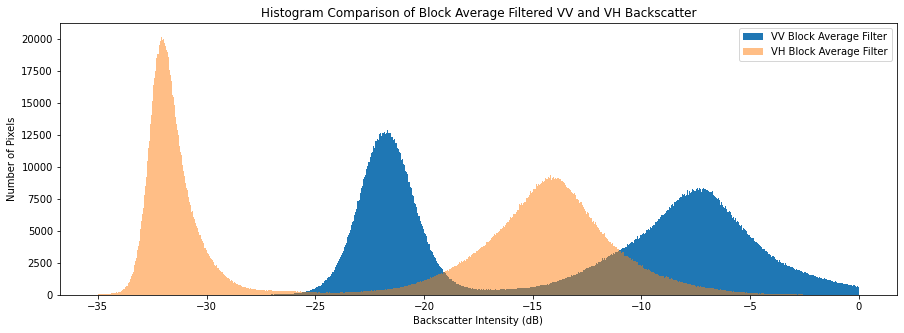

In [16]:
fig = plt.figure(figsize=(15, 5))
sar_dataset.isel(time=acq_ind_to_show).block_avg_filter_vv.plot.hist(bins=1000, range=(-35,0), 
                                                                 label="VV Block Average Filter")
sar_dataset.isel(time=acq_ind_to_show).block_avg_filter_vh.plot.hist(bins=1000, range=(-35,0), 
                                                                 label="VH Block Average Filter", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Histogram Comparison of Block Average Filtered VV and VH Backscatter")
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in VV and VH image products. This process is explained here. Sigma-nought backscatter (in dB units) is converted to linear amplitude (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final conversion equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [17]:
# This backscatter scaling is optimized for block-filtered data
# VV band range is 0dB to -16dB which is DN=1.00 to DN=0.158
# VH band range is -5dB to -27dB which is DN=0.562 to DN=0.045
# VV/VH range is 0.0 to 1.0. This data is scaled by 20 for improved color contrast

vv_convert = (10**(sar_dataset.block_avg_filter_vv/20)-0.158)*303
vh_convert = (10**(sar_dataset.block_avg_filter_vh/20)-0.045)*493
sar_dataset['vv_amp'] = vv_convert
sar_dataset['vh_amp'] = vh_convert
sar_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 20

## VV, VH and RGB images

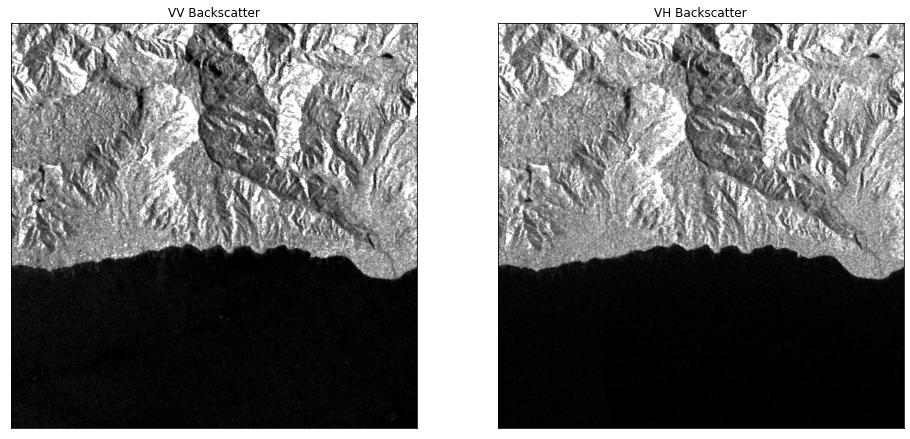

In [18]:
# Plots of VV and VH Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb(sar_dataset.isel(time=acq_ind_to_show), ax=ax[0], bands=['vv_amp','vv_amp','vv_amp'])
rgb(sar_dataset.isel(time=acq_ind_to_show), ax=ax[1], bands=['vh_amp','vh_amp','vh_amp'])
ax[0].set_title('VV Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('VH Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

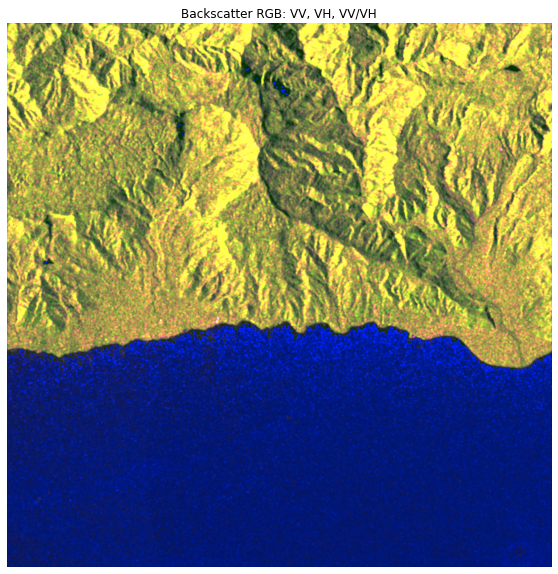

In [19]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# Urban areas are BRIGHT YELLOW or MAGENTA in color (due to high overall scattering at both VV and VH, 
# or, in the case of the magenta color, higher VV compared to VH)
# Sparsely vegetated and bare soil areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water (without wind or rain effects) is BLACK (very low backscatter in both bands with similar VV and VH)

rgb(sar_dataset.isel(time=acq_ind_to_show),bands=['vv_amp','vh_amp','vvvh_amp'], width=10)
plt.title('Backscatter RGB: VV, VH, VV/VH')
plt.axis('off')
plt.show()

## Single Date Single-Band Threshold Water Extent
The code below allows users to select a single date (use the index table above), a single band (e.g. VV or VH), and a water detection threshold value for the selected band. Review the histogram plots above to be sure the selected band and threshold are reasonable. It is common to use the VH band for water detection. The final product shows the water in BLUE color against a gray-scale VH-band background image. 

In [20]:
# MODIFY HERE

single_date = 1
single_variable = 'block_avg_filter_vh'
flood_threshold = -21.0

In [21]:
color_blue = np.array([0,0,255]) # Water (BLUE)
scene = sar_dataset.isel(time=single_date)
water = scene[single_variable].values < flood_threshold

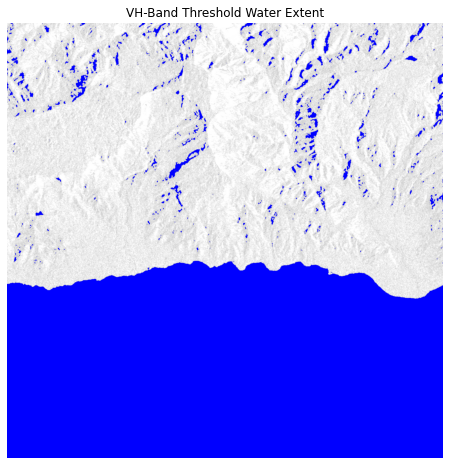

In [22]:
rgb(scene, bands=['vh', 'vh', 'vh'], 
    paint_on_mask=[(water, color_blue)], width=8, min_inten=0.6)
plt.title('VH-Band Threshold Water Extent')
plt.axis('off')
plt.show()

## Multi-Date Single-Band Threshold Flooding or Drought Product
The code below selects two dates, a variable (VV or VH) and a change threshold. The final product performs a comparison of the two dates and calculates the change in backscatter between those dates. Pixels with significant reduction in backscatter (e.g., loss of 7 dB) are likely changes from land to water due to flooding. Finding flooding requires comparisons of images from similar viewing angles. So, it is important to only compare acquisitions with the same orbit number. You will find that the same orbit number can come from two missions (6-day separation) or one mission (12-day separation) but the pass direction (ascending or descending) will be the same. 

In [23]:
# MODIFY HERE

# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above
# first_acq_ind = First time slice acquisition
# second_acq_ind = Second time slice acquisition

first_acq_ind = 0
second_acq_ind = 2

# Select the variable to plot: vv or vh

threshold_variable = 'block_avg_filter_vh'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range

threshold = -7

In [24]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_black = np.array([0,0,0]) # low backscatter change, water (BLACK)
color_blue2 = np.array([0,191,255]) # Water (CYAN)

first_acq = sar_dataset.isel(time=first_acq_ind)
second_acq = sar_dataset.isel(time=second_acq_ind)
change_product = second_acq[threshold_variable] - first_acq[threshold_variable]
below_threshold = change_product.values < threshold

In [25]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels in the first acquisition

water = first_acq[threshold_variable].values < -21.0

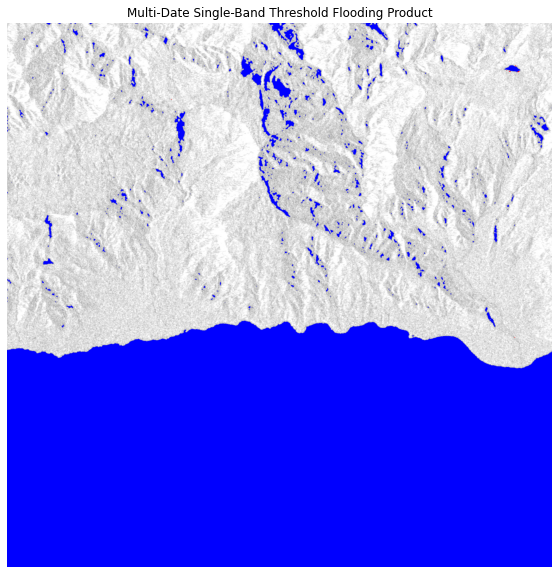

In [26]:
# Create a custom threshold plot to identify flooding
# The background image VV backscatter (grey-scale)
# RED areas have decreased backscatter indicative of new flooding
# BLACK areas are water in the first acquisition 

rgb(first_acq, bands=['vh', 'vh', 'vh'], 
paint_on_mask=[(below_threshold, color_loss),(water, color_blue)], width=10, min_inten=0.4)

plt.title('Multi-Date Single-Band Threshold Flooding Product')
plt.axis('off')
plt.show()